# Models Creation

In [3]:
import cv2
import numpy as np
import os
import sys
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
print(sys.version)

3.9.21 (main, Dec 11 2024, 16:24:11) 
[GCC 11.2.0]


In [5]:
!pip show tensorflow

Name: tensorflow
Version: 2.5.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /home/aherrerag/anaconda3/envs/proyecto_i3d/lib/python3.9/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras-nightly, keras-preprocessing, numpy, opt-einsum, protobuf, six, tensorboard, tensorflow-estimator, termcolor, typing-extensions, wheel, wrapt
Required-by: 


In [6]:
import tensorflow as tf

In [7]:
# Agrega el path al directorio raíz del proyecto
sys.path.append(os.path.abspath(".."))
from models.i3d import InceptionI3d

In [8]:
data = pd.read_csv("../data/ml/test.csv")

In [9]:
data

,Video,Evento,PCB,Start_Frame,End_Frame,duracion,Path,is_crime
0,Fighting051_x264.mp4,Fighting,989,1294,3355,2366,../data/test/Fighting051_x264.mp4,1
1,Normal_Videos086_x264.mp4,Normal,0,0,3391,3391,../data/test/Normal_Videos086_x264.mp4,0
2,Normal_Videos405_x264.mp4,Normal,0,0,1065,1065,../data/test/Normal_Videos405_x264.mp4,0
3,Normal_Videos134_x264.mp4,Normal,0,0,4476,4476,../data/test/Normal_Videos134_x264.mp4,0
4,Assault007_x264.mp4,Assault,330,668,1099,769,../data/test/Assault007_x264.mp4,1
...,...,...,...,...,...,...,...,...
60,Normal_Videos456_x264.mp4,Normal,0,0,3943,3943,../data/test/Normal_Videos456_x264.mp4,0
61,Assault013_x264.mp4,Assault,465,615,1022,557,../data/test/Assault013_x264.mp4,1
62,Assault047_x264.mp4,Assault,0,112,1790,1790,../data/test/Assault047_x264.mp4,1
63,Normal_Videos101_x264.mp4,Normal,0,0,1538,1538,../data/test/Normal_Videos101_x264.mp4,0


In [10]:
print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))

GPUs disponibles: []


2025-03-30 20:28:58.154674: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2025-03-30 20:28:58.205751: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:0a:00.0 name: NVIDIA A100 80GB PCIe computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 79.25GiB deviceMemoryBandwidth: 1.76TiB/s
2025-03-30 20:28:58.206759: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:ae:00.0 name: NVIDIA A100 80GB PCIe computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 79.25GiB deviceMemoryBandwidth: 1.76TiB/s
2025-03-30 20:28:58.206845: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/aherrerag/anaconda3/envs/proyecto

In [11]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU configurada con memory growth.")
    except RuntimeError as e:
        print(e)

In [12]:
# Dividir el dataset en train (80%), valid (10%), test (10%)
train_df, test_valid_df = train_test_split(data, test_size=0.2, random_state=42, stratify=data['is_crime'])
valid_df, test_df = train_test_split(test_valid_df, test_size=0.5, random_state=42)

## Data Loader

In [13]:
class VideoDataModule:
    def __init__(self, train_df, val_df, test_df, batch_size=8, frame_size=(224, 224), num_frames=32):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.frame_size = frame_size
        self.num_frames = num_frames

    def _load_video_frames(self, video_path, start_frame, end_frame):
        """
        Carga los frames de un video y los normaliza.

        Args:
            video_path: Ruta al video.
            start_frame: Frame inicial.
            end_frame: Frame final.

        Returns:
            frames: Tensor con los frames del video.
        """
        cap = cv2.VideoCapture(video_path)

        if not cap.isOpened():
            print(f"Error: No se pudo abrir el video {video_path}")
            return None

        frames = []
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Ajustar el rango si es necesario
        start_frame = int(start_frame) if not np.isnan(start_frame) else 0
        end_frame = int(end_frame) if not np.isnan(end_frame) else total_frames

        step = max(1, (end_frame - start_frame) // self.num_frames)

        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

        for _ in range(self.num_frames):
            ret, frame = cap.read()
            if not ret:
                break
            
            frame = cv2.resize(frame, self.frame_size)  # Redimensionar
            frame = frame / 255.0  # Normalizar a [0,1]
            frames.append(frame)

            for _ in range(step - 1):  # Saltar frames para ajustarse al total
                cap.read()

        cap.release()

        # Si el video es muy corto, rellenar con frames vacíos
        while len(frames) < self.num_frames:
            frames.append(np.zeros((*self.frame_size, 3)))

        return np.array(frames, dtype=np.float32)  # Shape: (num_frames, height, width, 3)

    def _dataframe_to_tf_dataset(self, df, shuffle=True):
        """
        Convierte un DataFrame en un tf.data.Dataset.

        Args:
            df: DataFrame con los datos.
            shuffle: Si se debe mezclar el dataset (por defecto True).

        Returns:
            dataset: tf.data.Dataset.
        """
        file_paths = df["Path"].values
        start_frames = df["PCB"].values
        end_frames = df["End_Frame"].values
        labels = df["is_crime"].values

        def generator():
            for i in range(len(file_paths)):
                video_tensor = self._load_video_frames(file_paths[i], start_frames[i], end_frames[i])
                yield video_tensor, labels[i]

        dataset = tf.data.Dataset.from_generator(
            generator,
            output_signature=(
                tf.TensorSpec(shape=(self.num_frames, *self.frame_size, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int32),
            ),
        )

        if shuffle:
            dataset = dataset.shuffle(buffer_size=len(df))

        dataset = dataset.batch(self.batch_size).prefetch(tf.data.AUTOTUNE)
        return dataset

    def train_dataset(self):
        return self._dataframe_to_tf_dataset(self.train_df, shuffle=True)

    def val_dataset(self):
        return self._dataframe_to_tf_dataset(self.val_df, shuffle=False)

    def test_dataset(self):
        return self._dataframe_to_tf_dataset(self.test_df, shuffle=False)

## I3D Model

In [14]:
# Clase adaptadora para usar InceptionI3D como modelo de Keras
class KerasI3D(tf.keras.Model):
    def __init__(self, num_classes, endpoint = "Logits"):
        super(KerasI3D, self).__init__()
        self.i3d = InceptionI3d(num_classes=num_classes, is_training=True, final_endpoint=endpoint)

    def call(self, inputs, training=False):
        logits, _ = self.i3d(inputs)  # El modelo I3D devuelve logits y endpoints
        return logits

In [15]:
# Crear el DataModule
data_module = VideoDataModule(train_df, valid_df, test_df, batch_size=8)
# Obtener los datasets
train_dataset = data_module.train_dataset()
val_dataset = data_module.val_dataset()
test_dataset = data_module.test_dataset()

2025-03-30 20:28:58.319425: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-30 20:28:58.326598: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2025-03-30 20:28:58.326616: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      


### One Cycle Policy

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.metrics import AUC

In [17]:
epochs = 2  # Número de épocas
max_learning_rate = 0.1  # Ejemplo
initial_learning_rate = 1e-5  # Ejemplo
num_classes = 2

In [18]:
import numpy as np

def one_cycle_scheduler(epoch, lr):
    """Implementación corregida de One Cycle Policy."""
    total_epochs = epochs
    max_lr = max_learning_rate
    min_lr = initial_learning_rate / 10
    mid_epoch = total_epochs // 2
    
    if epoch < mid_epoch:
        # Aumento del learning rate (fase de warm-up)
        return initial_learning_rate + (max_lr - initial_learning_rate) * (epoch / mid_epoch)
    else:
        # Disminución más suave del learning rate (fase de cooldown)
        return min_lr + (max_lr - min_lr) * 0.5 * (1 + np.cos((epoch - mid_epoch) / mid_epoch * np.pi))


### Modelo

In [19]:
# Crear el DataModule
data_module = VideoDataModule(train_df, valid_df, test_df, batch_size=8)
# Obtener los datasets
train_dataset = data_module.train_dataset()
val_dataset = data_module.val_dataset()
test_dataset = data_module.test_dataset()

model_1 = KerasI3D(num_classes=num_classes)
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_1.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

In [23]:
checkpoint_dir = "checkpoints/i3d_model"
os.makedirs(checkpoint_dir, exist_ok=True)

last_epoch_file = os.path.join(checkpoint_dir, "last_epoch.npy")
history_file = os.path.join(checkpoint_dir, "history.npy")

# Intentar cargar la última época guardada
if os.path.exists(last_epoch_file):
    initial_epoch = int(np.load(last_epoch_file))
    model_1.load_weights(os.path.join(checkpoint_dir, "model_best"))  # Cargar pesos previos
    print(f"Resuming training from epoch {initial_epoch}")
else:
    initial_epoch = 0
    print("Starting training from scratch.")

# Callbacks
early_stop_callback = EarlyStopping(
    monitor="val_loss", 
    patience=3, 
    mode="min", 
    restore_best_weights=True
)

checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "model_best"),
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    save_weights_only=True
)

lr_scheduler = LearningRateScheduler(one_cycle_scheduler)

# Callback para guardar la época actual
class EpochSaver(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        np.save(last_epoch_file, epoch + 1)  # Guardar la siguiente época a entrenar

epoch_saver_callback = EpochSaver()

# Cargar historial previo si existe
if os.path.exists(history_file):
    history_full = np.load(history_file, allow_pickle=True).item()
else:
    history_full = {'loss': [], 'val_loss': []}

# Verificar si el entrenamiento ya ha terminado
if initial_epoch >= epochs:
    print("Training already completed. No new epochs to run.")
else:
    # Entrenar desde la última época
    history = model_1.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        initial_epoch=initial_epoch,  # Reinicia en la última época guardada
        callbacks=[early_stop_callback, checkpoint_callback, lr_scheduler, epoch_saver_callback],
        verbose=1
    )

    # Verificar que history.history no está vacío antes de extender
    if 'loss' in history.history and 'val_loss' in history.history:
        history_full['loss'].extend(history.history['loss'])
        history_full['val_loss'].extend(history.history['val_loss'])

    # Guardar historial actualizado
    np.save(history_file, history_full)

Resuming training from epoch 2
Training already completed. No new epochs to run.


In [24]:
history_full

{'loss': [5.671295166015625, 5.581493854522705],
 'val_loss': [2.2925796508789062, 4.552292346954346]}

### Evolución del Learning rate

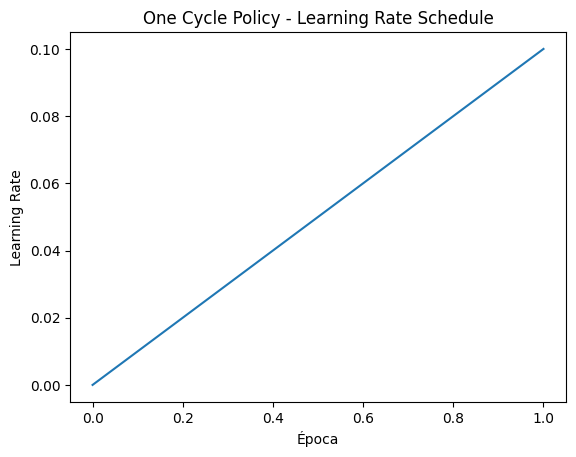

In [25]:
import matplotlib.pyplot as plt  # Corrección en la importación
lrs = [one_cycle_scheduler(epoch, initial_learning_rate) for epoch in range(epochs)]
plt.plot(range(epochs), lrs)
plt.xlabel("Época")
plt.ylabel("Learning Rate")
plt.title("One Cycle Policy - Learning Rate Schedule")
plt.show()

In [26]:
train_results = model_1.evaluate(train_dataset, verbose=1)

2025-03-30 20:32:08.200208: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2025-03-30 20:32:08.218284: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2100000000 Hz
2025-03-30 20:32:20.807855: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 25 of 52
2025-03-30 20:32:28.945850: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


7/7 [==============================] - 38s 1s/step - loss: 2.0565 - accuracy: 0.4808


In [27]:
# Evaluar en el conjunto de validación
val_results = model_1.evaluate(val_dataset, verbose=1)

1/1 [==============================] - 3s 3s/step - loss: 4.5523 - accuracy: 0.3333


In [28]:
# Evaluar en el conjunto de prueba
test_results = model_1.evaluate(test_dataset, verbose=1)

1/1 [==============================] - 3s 3s/step - loss: 0.7113 - accuracy: 0.4286


In [29]:
print("\nResultados Finales:")
print(f"Train - Loss: {train_results[0]}, Accuracy: {train_results[1]}")
print(f"Val - Loss: {val_results[0]}, Accuracy: {val_results[1]}")
print(f"Test - Loss: {test_results[0]}, Accuracy: {test_results[1]}")


Resultados Finales:
Train - Loss: 2.0564844608306885, Accuracy: 0.48076921701431274
Val - Loss: 4.552292346954346, Accuracy: 0.3333333432674408
Test - Loss: 0.7112869024276733, Accuracy: 0.4285714328289032


### Gráfica Epochs vs Loss

In [30]:
history_full

{'loss': [5.671295166015625, 5.581493854522705],
 'val_loss': [2.2925796508789062, 4.552292346954346]}

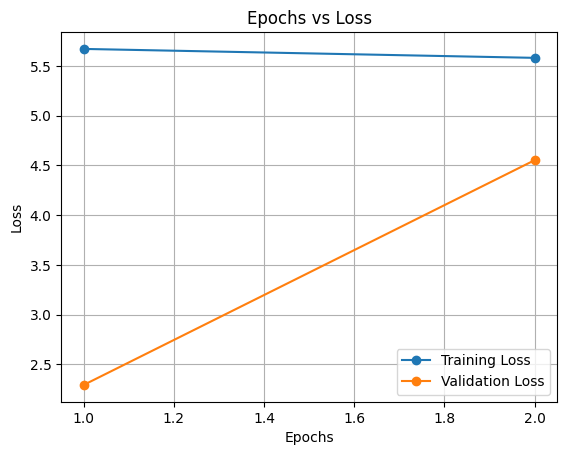

In [31]:
import matplotlib.pyplot as plt
# Extraer la pérdida de entrenamiento y validación
loss = history_full['loss']
val_loss = history_full['val_loss']

# Crear la gráfica
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss', marker='o')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', marker='o')

# Etiquetas y título
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epochs vs Loss')
plt.legend()
plt.grid(True)
plt.show()

### Visualización del Modelo con TSNE

Num samples: 7, Usando perplexity=6


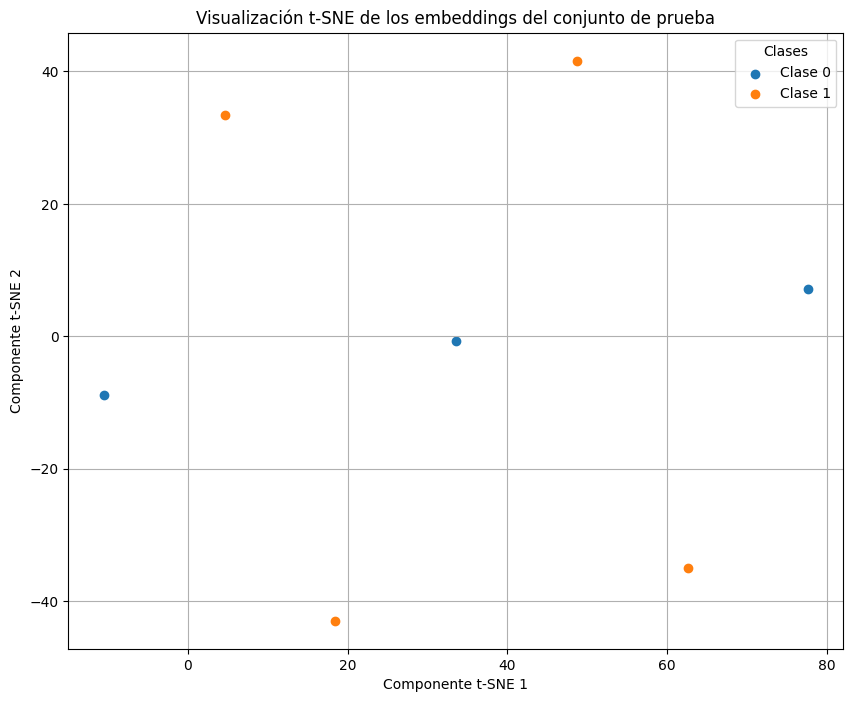

In [32]:
from sklearn.manifold import TSNE

# Obtener las representaciones del modelo
x_test = model_1.predict(test_dataset)  # Extrae los embeddings
y_test = np.concatenate([y for _, y in test_dataset])  # Obtener etiquetas reales

# Verificar el número de muestras
num_samples = x_test.shape[0]
perplexity_value = min(10, num_samples - 1)  # Ajustar perplexity dinámicamente

print(f"Num samples: {num_samples}, Usando perplexity={perplexity_value}")

# Aplicar t-SNE con un perplexity válido
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
x_test_tsne = tsne.fit_transform(x_test)

# Visualización
plt.figure(figsize=(10, 8))
for i in np.unique(y_test):
    idx = np.where(y_test == i)[0]
    plt.scatter(x_test_tsne[idx, 0], x_test_tsne[idx, 1], label=f"Clase {i}")

plt.title("Visualización t-SNE de los embeddings del conjunto de prueba")
plt.xlabel("Componente t-SNE 1")
plt.ylabel("Componente t-SNE 2")
plt.legend(title="Clases")
plt.grid(True)
plt.show()

## I3D + ConvLSTM2D

In [41]:
from tensorflow.keras.layers import (ConvLSTM2D, TimeDistributed, Dense, 
                                    Flatten, GlobalAveragePooling2D, 
                                    Dropout, BatchNormalization)
from tensorflow.keras import Model

class I3D_ConvLSTM(Model):
    def __init__(self, num_classes, endpoint="Mixed_5c"):
        super(I3D_ConvLSTM, self).__init__()
        
        # Modelo base Inception I3D
        self.i3d = InceptionI3d(num_classes=num_classes, is_training=True, final_endpoint=endpoint)
        
        # Capa ConvLSTM2D para modelar información temporal
        self.conv_lstm = ConvLSTM2D(
            filters=64, 
            kernel_size=(3, 3),
            padding='same',
            return_sequences=True,  # Mantener la dimensión temporal
            dropout=0.2,
            recurrent_dropout=0.2
        )
        
        # Batch Normalization después de ConvLSTM
        self.batch_norm = BatchNormalization()
        
        # Global Average Pooling para reducir dimensionalidad
        self.global_avg_pool = GlobalAveragePooling2D()  # Cambio a 2D
        
        # Dropout para regularización
        self.dropout = Dropout(0.3)
        
        # Capa completamente conectada final
        self.fc = Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        """Entrada esperada: (batch_size, num_frames, height, width, channels)"""
        
        # Extraer características con I3D
        features, _ = self.i3d(inputs)  # (batch_size, num_frames, 7, 7, 1024)
        
        # Aplicar ConvLSTM2D sobre la dimensión temporal
        lstm_out = self.conv_lstm(features)  # (batch_size, num_frames, 7, 7, 64)
        
        # Tomar solo el último frame de la salida de LSTM para clasificación
        lstm_out = lstm_out[:, -1, :, :, :]  # (batch_size, 7, 7, 64)

        # Batch Normalization
        x = self.batch_norm(lstm_out, training=training)
        
        # Global Average Pooling
        x = self.global_avg_pool(x)
        
        # Dropout para regularización
        x = self.dropout(x, training=training)
        
        # Capa de salida
        logits = self.fc(x)
        
        return logits

In [40]:
# Crear el DataModule
data_module = VideoDataModule(train_df, valid_df, test_df, batch_size=8)
# Obtener los datasets
train_dataset = data_module.train_dataset()
val_dataset = data_module.val_dataset()
test_dataset = data_module.test_dataset()

### Modelo

In [42]:
epochs = 2  # Número de épocas
max_learning_rate = 0.1  # Ejemplo
initial_learning_rate = 1e-5  # Ejemplo
num_classes = 2

In [43]:
model_2 = I3D_ConvLSTM(num_classes=num_classes)
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_2.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

In [44]:
checkpoint_dir = "checkpoints/i3dLstm_model"
os.makedirs(checkpoint_dir, exist_ok=True)

last_epoch_file = os.path.join(checkpoint_dir, "last_epoch.npy")
history_file = os.path.join(checkpoint_dir, "history.npy")

# Intentar cargar la última época guardada
if os.path.exists(last_epoch_file):
    initial_epoch = int(np.load(last_epoch_file))
    model_2.load_weights(os.path.join(checkpoint_dir, "model_best"))  # Cargar pesos previos
    print(f"Resuming training from epoch {initial_epoch}")
else:
    initial_epoch = 0
    print("Starting training from scratch.")

# Callbacks
early_stop_callback = EarlyStopping(
    monitor="val_loss", 
    patience=3, 
    mode="min", 
    restore_best_weights=True
)

checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "model_best"),
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    save_weights_only=True
)

lr_scheduler = LearningRateScheduler(one_cycle_scheduler)

# Callback para guardar la época actual
class EpochSaver(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        np.save(last_epoch_file, epoch + 1)  # Guardar la siguiente época a entrenar

epoch_saver_callback = EpochSaver()

# Cargar historial previo si existe
if os.path.exists(history_file):
    history_full = np.load(history_file, allow_pickle=True).item()
else:
    history_full = {'loss': [], 'val_loss': []}

# Verificar si el entrenamiento ya ha terminado
if initial_epoch >= epochs:
    print("Training already completed. No new epochs to run.")
else:
    # Entrenar desde la última época
    history = model_2.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        initial_epoch=initial_epoch,  # Reinicia en la última época guardada
        callbacks=[early_stop_callback, checkpoint_callback, lr_scheduler, epoch_saver_callback],
        verbose=1
    )

    # Verificar que history.history no está vacío antes de extender
    if 'loss' in history.history and 'val_loss' in history.history:
        history_full['loss'].extend(history.history['loss'])
        history_full['val_loss'].extend(history.history['val_loss'])

    # Guardar historial actualizado
    np.save(history_file, history_full)

Starting training from scratch.
Epoch 1/2


/home/aherrerag/anaconda3/envs/proyecto_i3d/lib/python3.9/site-packages/tensorflow/python/keras/backend.py:4929: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(
2025-03-30 20:40:32.625178: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2025-03-30 20:40:53.641494: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 22 of 52
2025-03-30 20:41:02.947104: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


7/7 [==============================] - 636s 85s/step - loss: 0.6864 - accuracy: 0.5385 - val_loss: 0.6522 - val_accuracy: 0.6667
Epoch 2/2


2025-03-30 20:51:13.407945: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 52
2025-03-30 20:51:21.200163: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


7/7 [==============================] - 612s 84s/step - loss: 0.8948 - accuracy: 0.4231 - val_loss: 0.6632 - val_accuracy: 0.6667


In [45]:
train_results = model_2.evaluate(train_dataset, verbose=1)

2025-03-30 21:02:55.978705: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 25 of 52
2025-03-30 21:03:04.081793: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


7/7 [==============================] - 26s 1s/step - loss: 0.8855 - accuracy: 0.5000


In [46]:
# Evaluar en el conjunto de validación
val_results = model_2.evaluate(val_dataset, verbose=1)

1/1 [==============================] - 3s 3s/step - loss: 0.6632 - accuracy: 0.6667


In [47]:
# Evaluar en el conjunto de prueba
test_results = model_2.evaluate(test_dataset, verbose=1)

1/1 [==============================] - 3s 3s/step - loss: 1.0049 - accuracy: 0.4286


In [48]:
print("\nResultados Finales:")
print(f"Train - Loss: {train_results[0]}, Accuracy: {train_results[1]}")
print(f"Val - Loss: {val_results[0]}, Accuracy: {val_results[1]}")
print(f"Test - Loss: {test_results[0]}, Accuracy: {test_results[1]}")


Resultados Finales:
Train - Loss: 0.8855320811271667, Accuracy: 0.5
Val - Loss: 0.663181483745575, Accuracy: 0.6666666865348816
Test - Loss: 1.0049265623092651, Accuracy: 0.4285714328289032


### Evolución del Learning rate

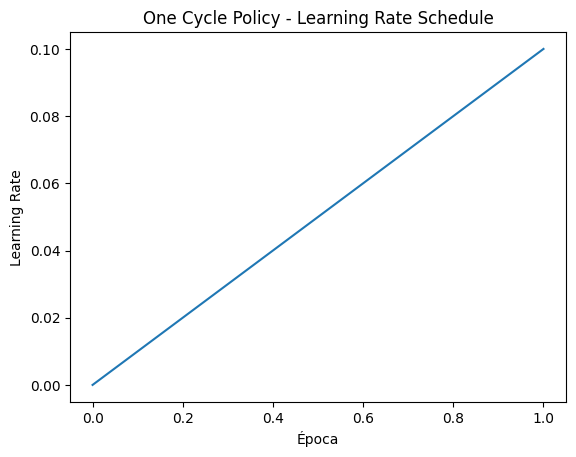

In [49]:
import matplotlib.pyplot as plt  # Corrección en la importación
lrs = [one_cycle_scheduler(epoch, initial_learning_rate) for epoch in range(epochs)]
plt.plot(range(epochs), lrs)
plt.xlabel("Época")
plt.ylabel("Learning Rate")
plt.title("One Cycle Policy - Learning Rate Schedule")
plt.show()

### Gráfica Epochs vs Loss

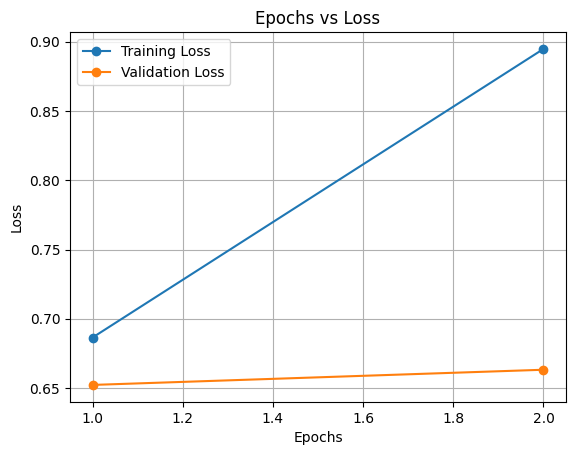

In [50]:
import matplotlib.pyplot as plt

# Extraer la pérdida de entrenamiento y validación
loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear la gráfica
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss', marker='o')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', marker='o')

# Etiquetas y título
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epochs vs Loss')
plt.legend()
plt.grid(True)
plt.show()

### Visualización del Modelo con TSNE

Num samples: 7, Usando perplexity=6


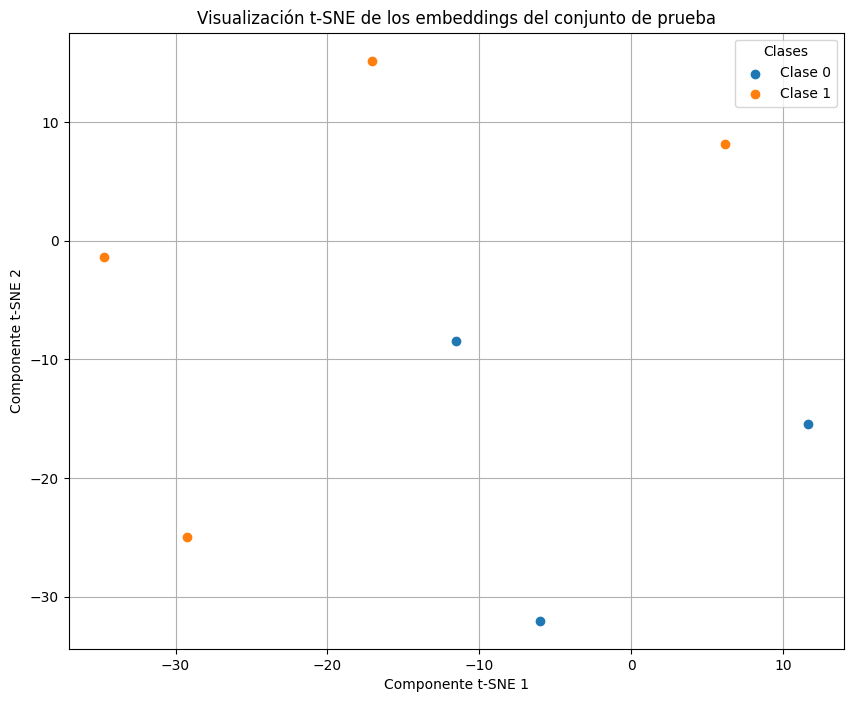

In [51]:
from sklearn.manifold import TSNE

# Obtener las representaciones del modelo
x_test = model_2.predict(test_dataset)  # Extrae los embeddings
y_test = np.concatenate([y for _, y in test_dataset])  # Obtener etiquetas reales

# Verificar el número de muestras
num_samples = x_test.shape[0]
perplexity_value = min(10, num_samples - 1)  # Ajustar perplexity dinámicamente

print(f"Num samples: {num_samples}, Usando perplexity={perplexity_value}")

# Aplicar t-SNE con un perplexity válido
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
x_test_tsne = tsne.fit_transform(x_test)

# Visualización
plt.figure(figsize=(10, 8))
for i in np.unique(y_test):
    idx = np.where(y_test == i)[0]
    plt.scatter(x_test_tsne[idx, 0], x_test_tsne[idx, 1], label=f"Clase {i}")

plt.title("Visualización t-SNE de los embeddings del conjunto de prueba")
plt.xlabel("Componente t-SNE 1")
plt.ylabel("Componente t-SNE 2")
plt.legend(title="Clases")
plt.grid(True)
plt.show()

## Comparación de modelos

In [43]:
# Evaluar los modelos en el conjunto de prueba
loss_1, acc_1 = model_1.evaluate(X_test, y_test)
loss_2, acc_2 = model_2.evaluate(X_test, y_test)

print(f"KerasI3D - Loss: {loss_1}, Accuracy: {acc_1}")
print(f"I3D_ConvLSTM - Loss: {loss_2}, Accuracy: {acc_2}")

NameError: name 'X_test' is not defined